In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import welch
import threading


In [13]:
# File paths
eeg_data_path = "/Users/puchku-home/KIIT SEM/PROJECT/EEG/chbmit_preprocessed_data.csv"
seizure_info_path = "/Users/puchku-home/KIIT SEM/PROJECT/EEG/sizuretimes.xlsx" 

In [14]:
# 🔹 Load EEG Data
def load_eeg_data(result_dict):
    if not os.path.exists(eeg_data_path):
        print(f"❌ File not found: {eeg_data_path}")
        result_dict["eeg"] = (None, None)
        return
    
    df = pd.read_csv(eeg_data_path)

    print("📂 EEG Data Loaded. Shape:", df.shape)  # Show dataset size
    
    # Extract time and EEG channel data
    time = np.arange(len(df)) / 256  # Generate time array assuming 256 Hz sampling rate
    eeg_signals = df.iloc[:, :-1]  # Extract all EEG channels (excluding Outcome column)

    result_dict["eeg"] = (time, eeg_signals)

In [15]:
# 🔹 Load Seizure Information for Each Patient
def load_seizure_info(patient_id, result_dict):
    sheet_name = f"chb{str(patient_id).zfill(2)}"
    if not os.path.exists(seizure_info_path):
        print(f"❌ Seizure info file not found: {seizure_info_path}")
        result_dict[patient_id] = None
        return

    try:
        seizure_df = pd.read_excel(seizure_info_path, sheet_name=sheet_name, engine="openpyxl")
        print(f"📊 Seizure info loaded for Patient {patient_id}")
        result_dict[patient_id] = seizure_df
    except Exception as e:
        print(f"⚠ Error loading seizure info for Patient {patient_id}: {e}")
        result_dict[patient_id] = None

In [16]:
def psd_plot(fs, time, eeg_signals, patient_id):
    plt.figure(figsize=(12, 6))
    cmap = plt.get_cmap("tab20")  # Better color map
    
    for i in range(eeg_signals.shape[1]):  
        f, Pxx = welch(eeg_signals.iloc[:, i], fs=fs, nperseg=2048, window='hann', scaling='density')
        plt.plot(f, Pxx, label=f'Channel {i+1}', color=cmap(i % 20))  # Assign unique colors
        
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (μV²/Hz)")
    plt.title(f"Power Spectral Density - Patient {patient_id}")
    plt.grid()
    
    plt.xlim(1, 50)  # Skip the very low frequencies

    plt.yscale('log')  # Use logarithmic scale for better spread
    plt.ylim(1e-11, 1e-8)  # Adjust Y-axis range for clarity

    
    # ✅ Move the legend outside the graph
    plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=10, ncol=1)
    
    plt.tight_layout()  # Adjust layout to prevent cutting off
    plt.show()


📂 EEG Data Loaded. Shape: (2097150, 24)
📊 Seizure info loaded for Patient 1


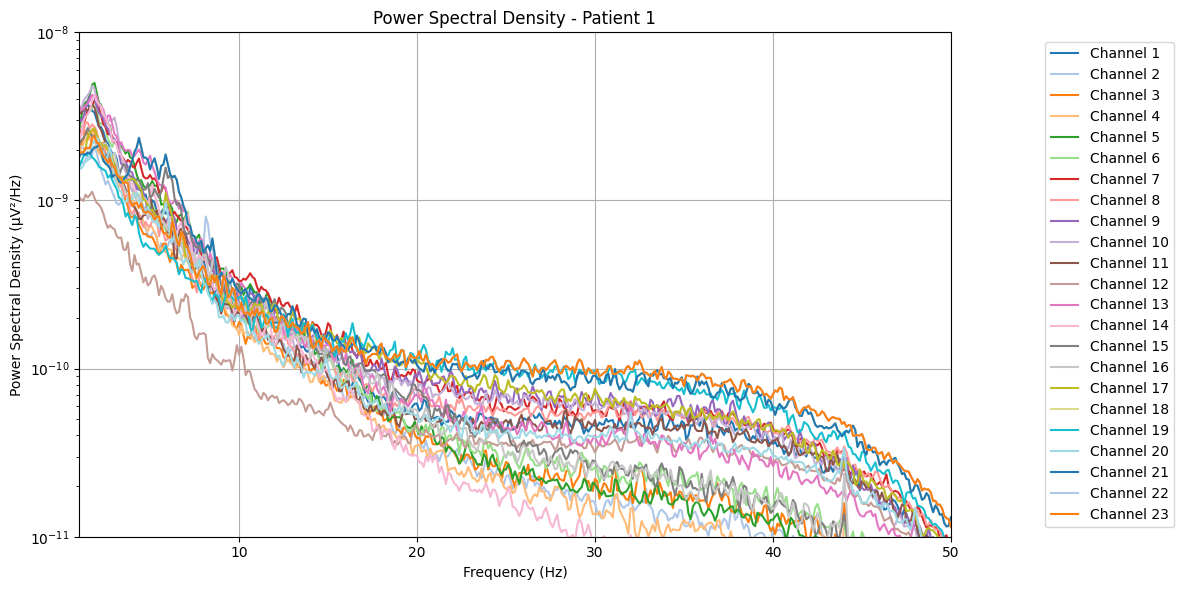

📊 Seizure info loaded for Patient 2


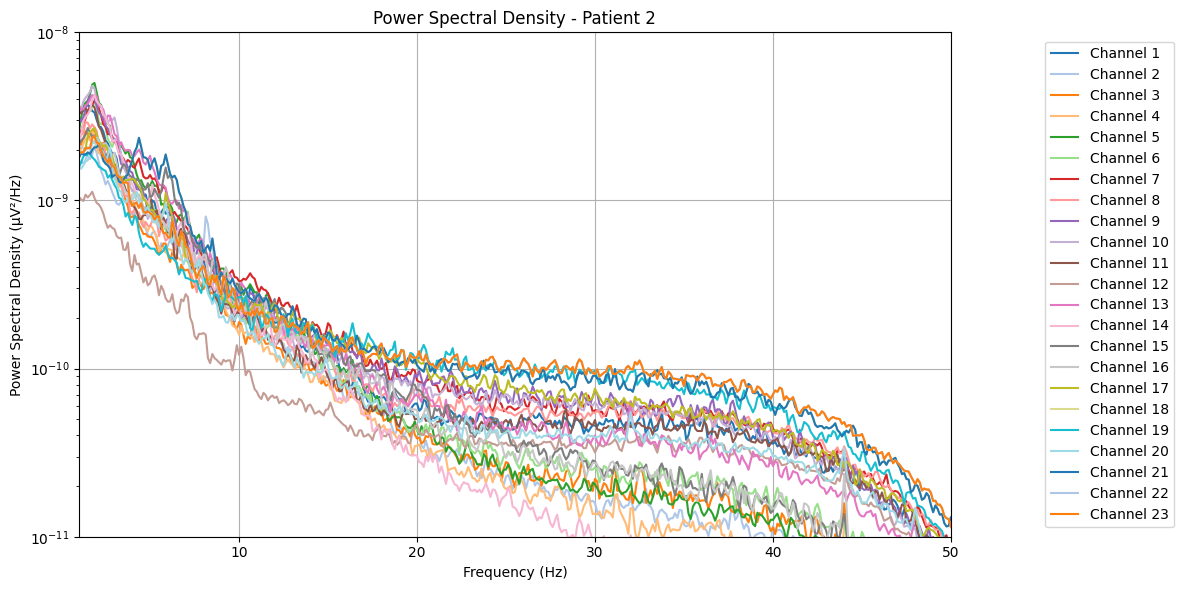

📊 Seizure info loaded for Patient 3


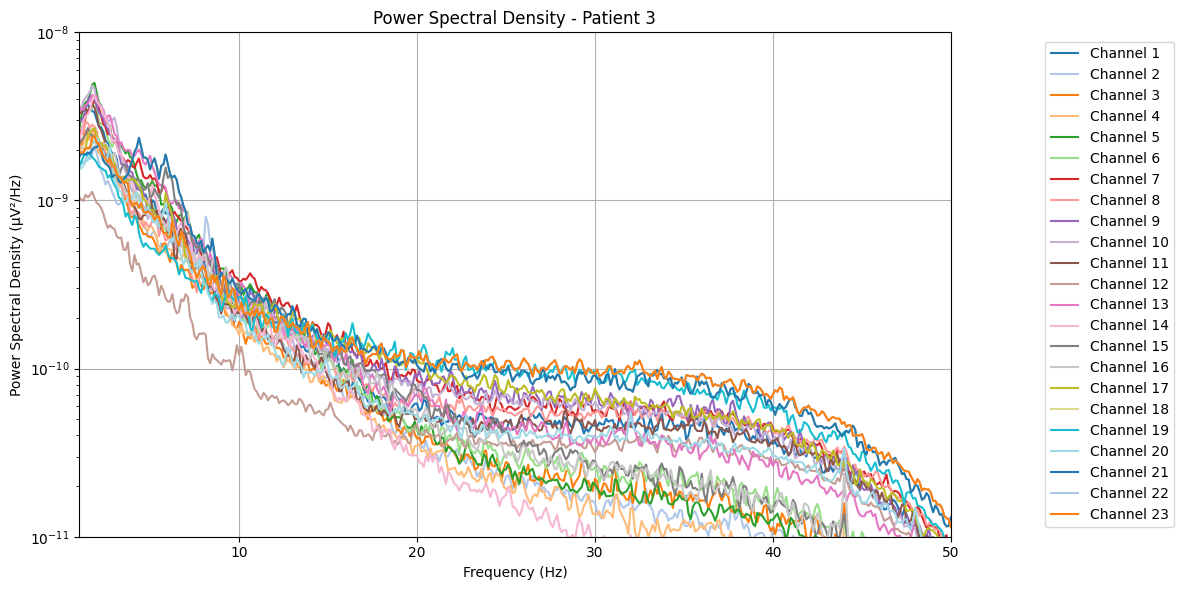

📊 Seizure info loaded for Patient 4


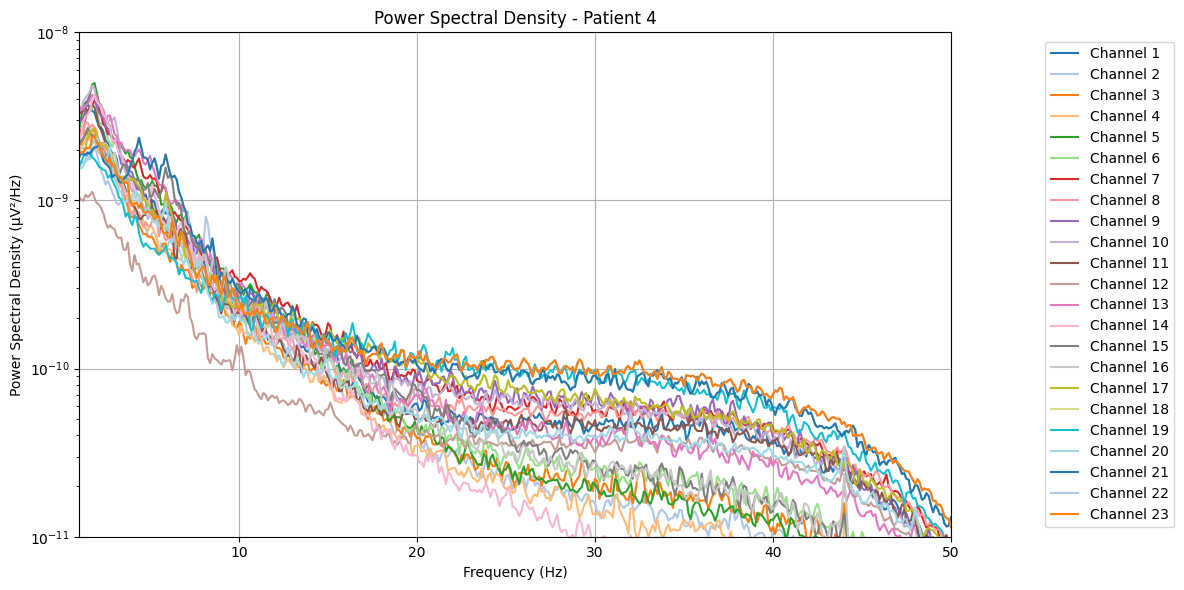

📊 Seizure info loaded for Patient 5


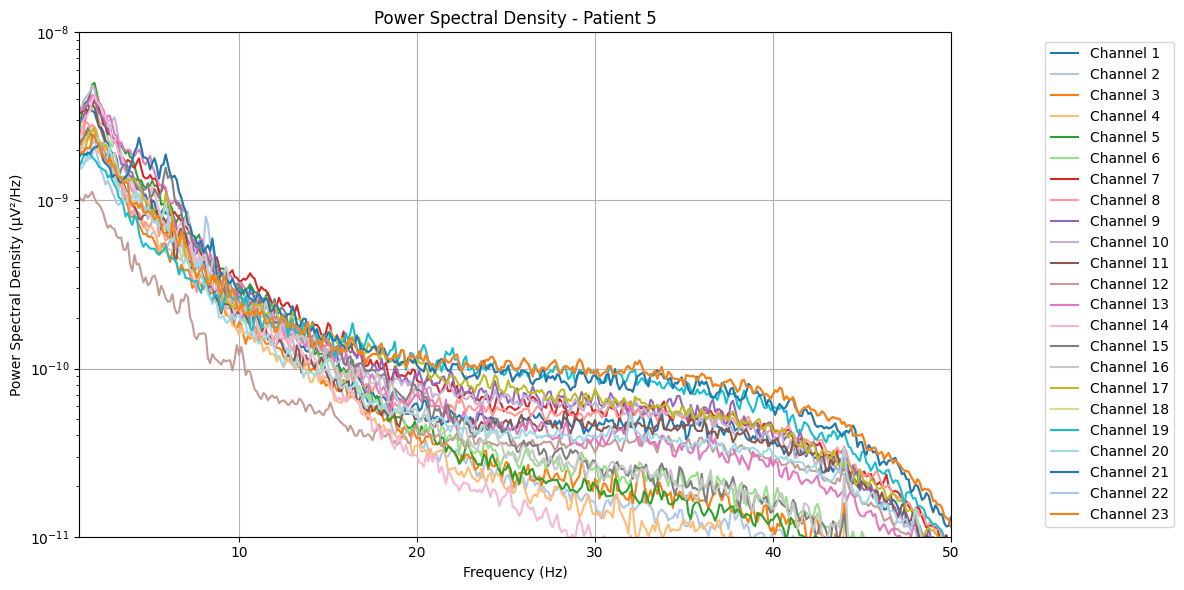

📊 Seizure info loaded for Patient 6


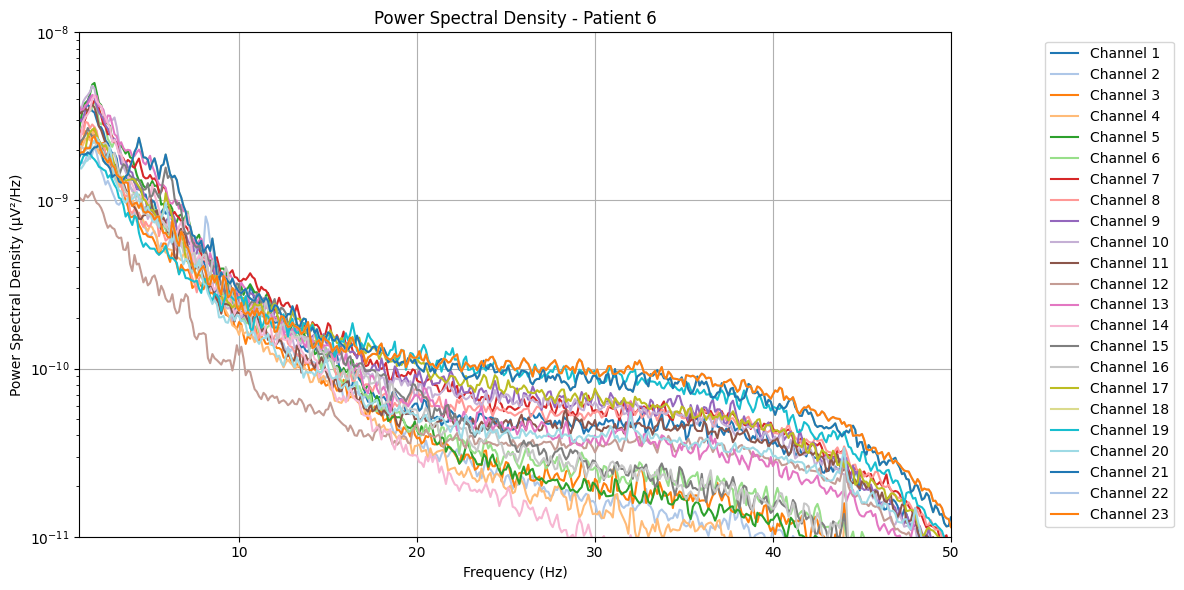

📊 Seizure info loaded for Patient 7


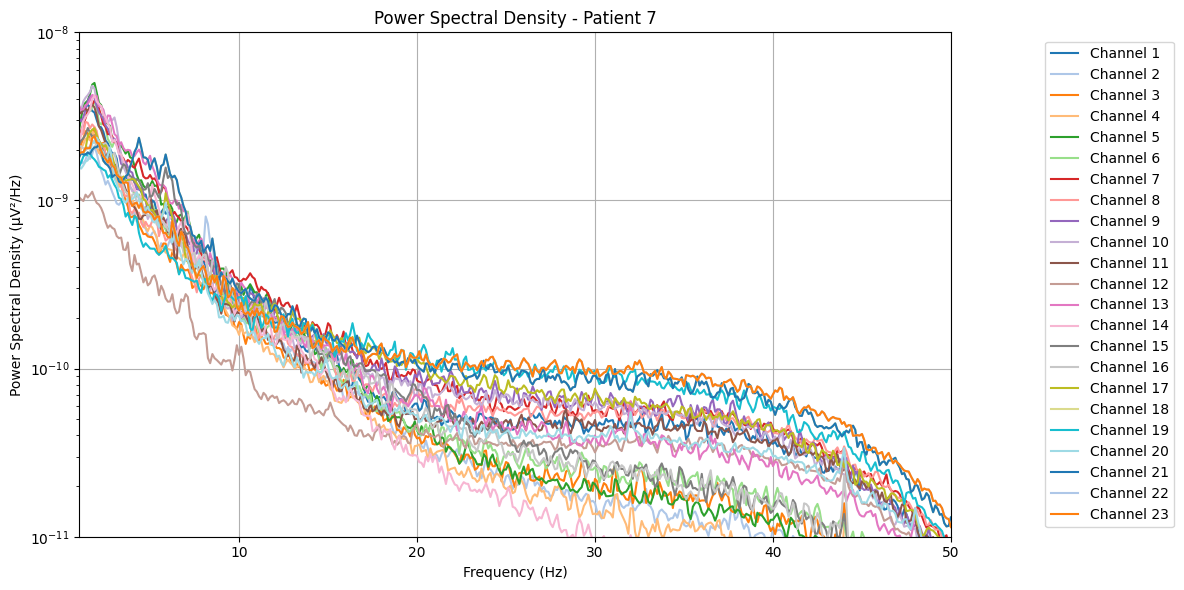

📊 Seizure info loaded for Patient 8


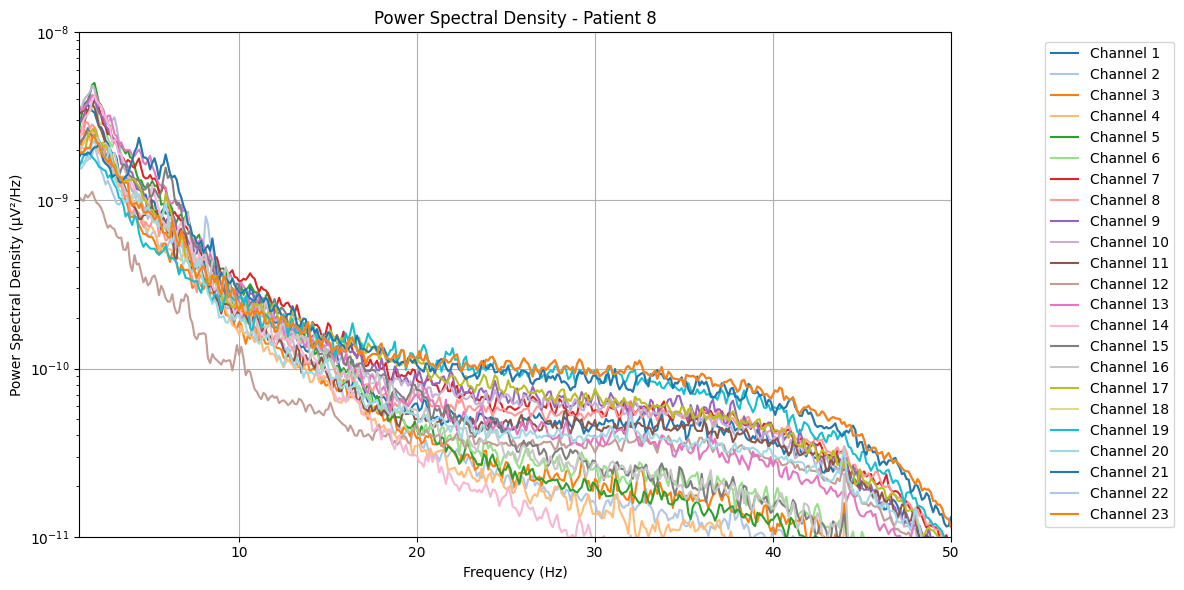

📊 Seizure info loaded for Patient 9


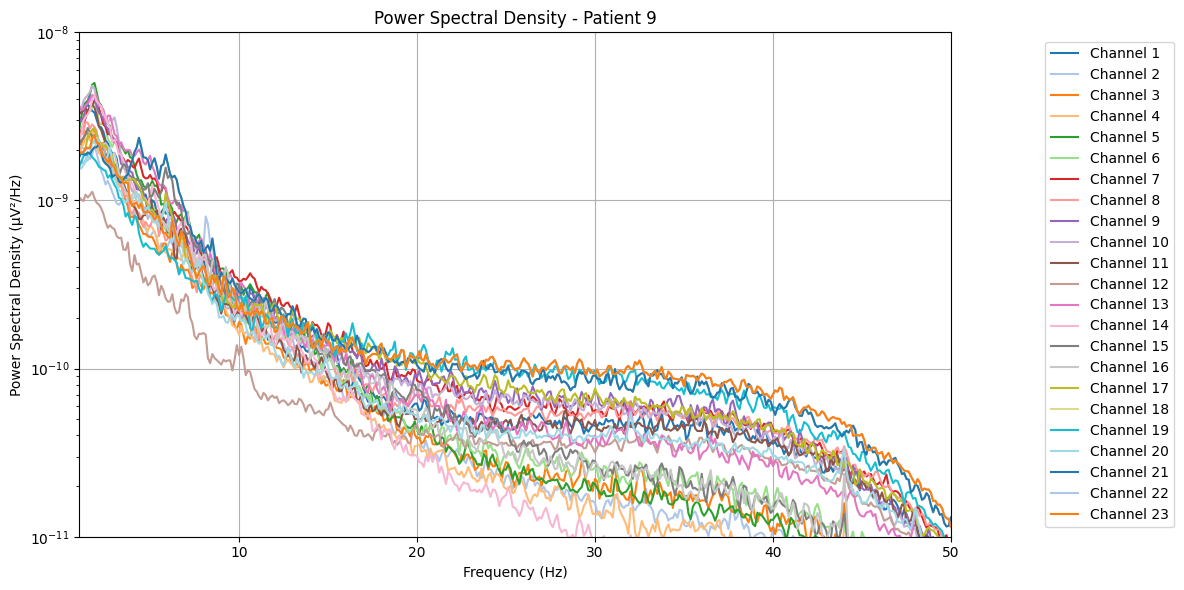

📊 Seizure info loaded for Patient 10


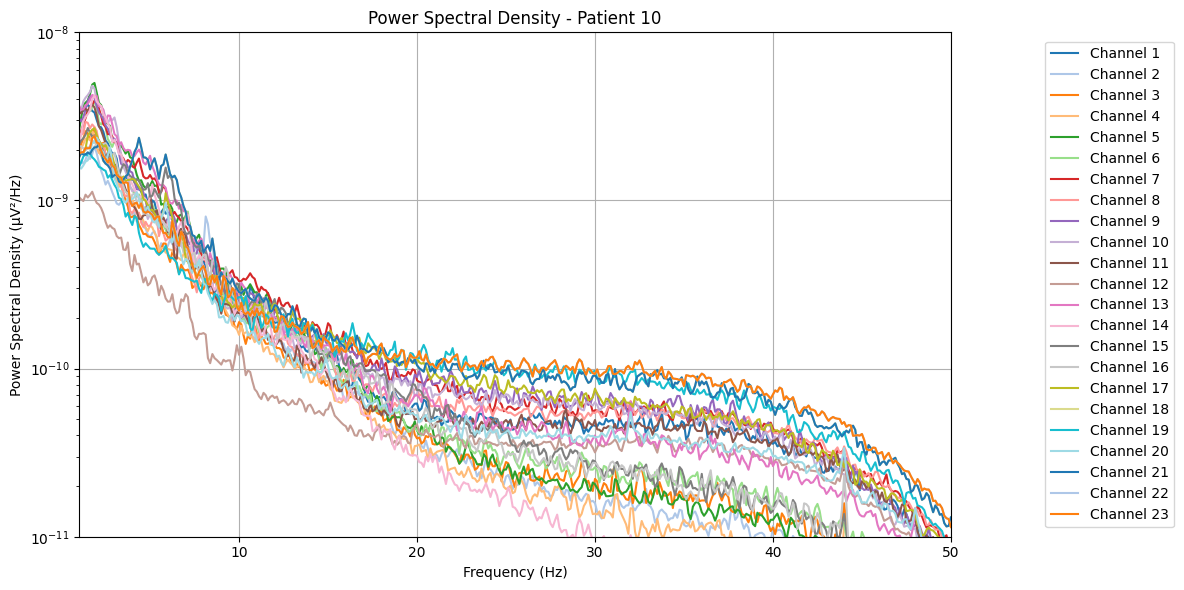

📊 Seizure info loaded for Patient 11


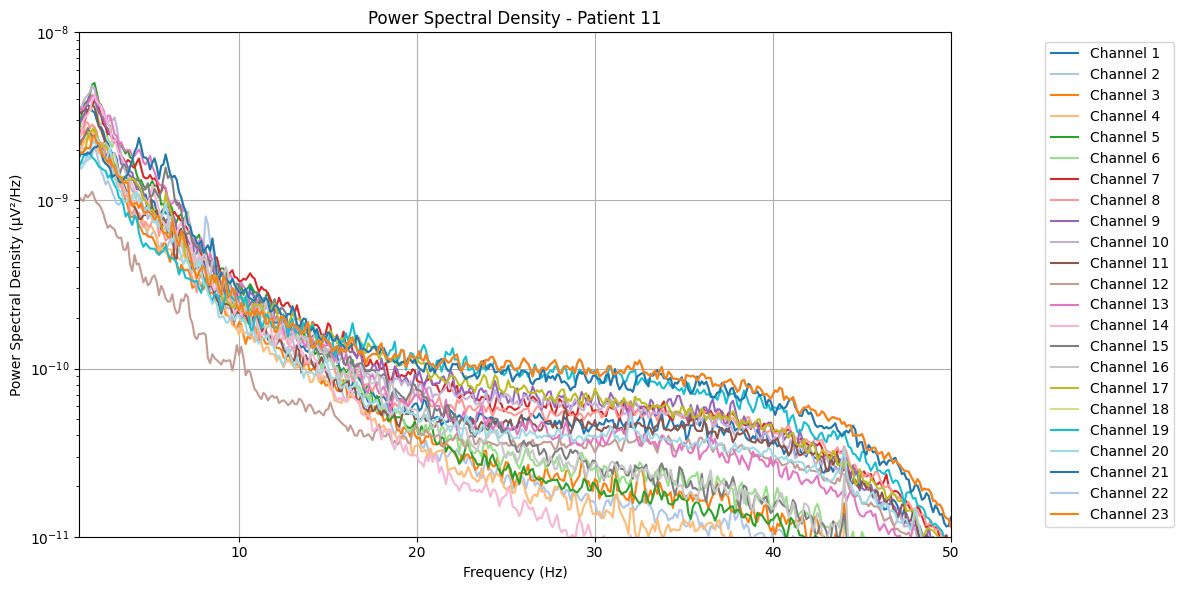

📊 Seizure info loaded for Patient 12


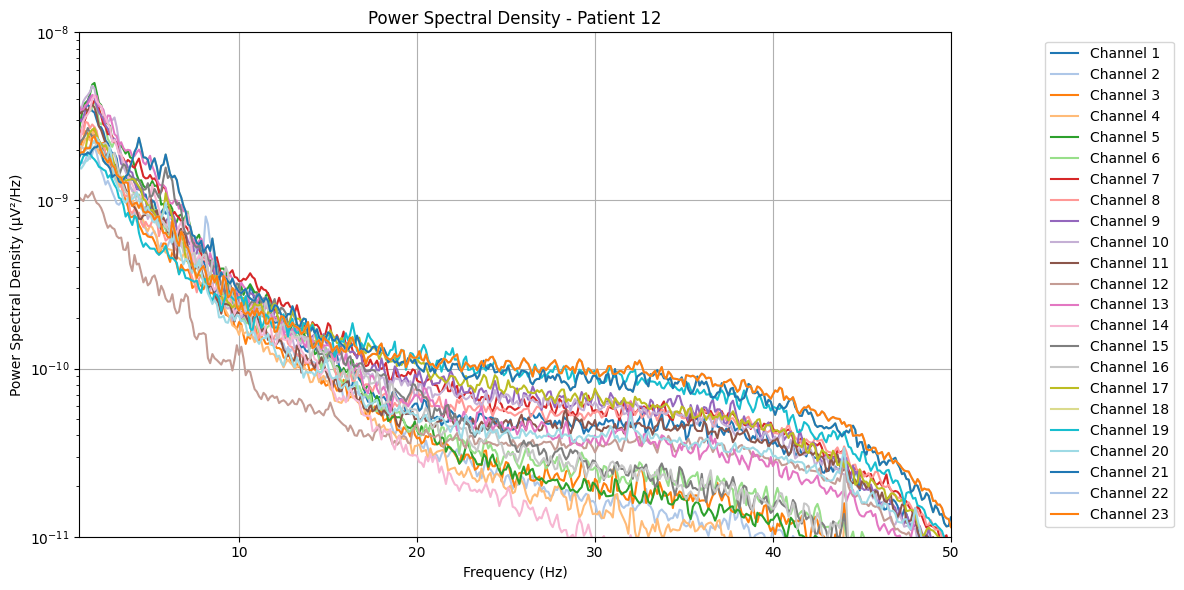

📊 Seizure info loaded for Patient 13


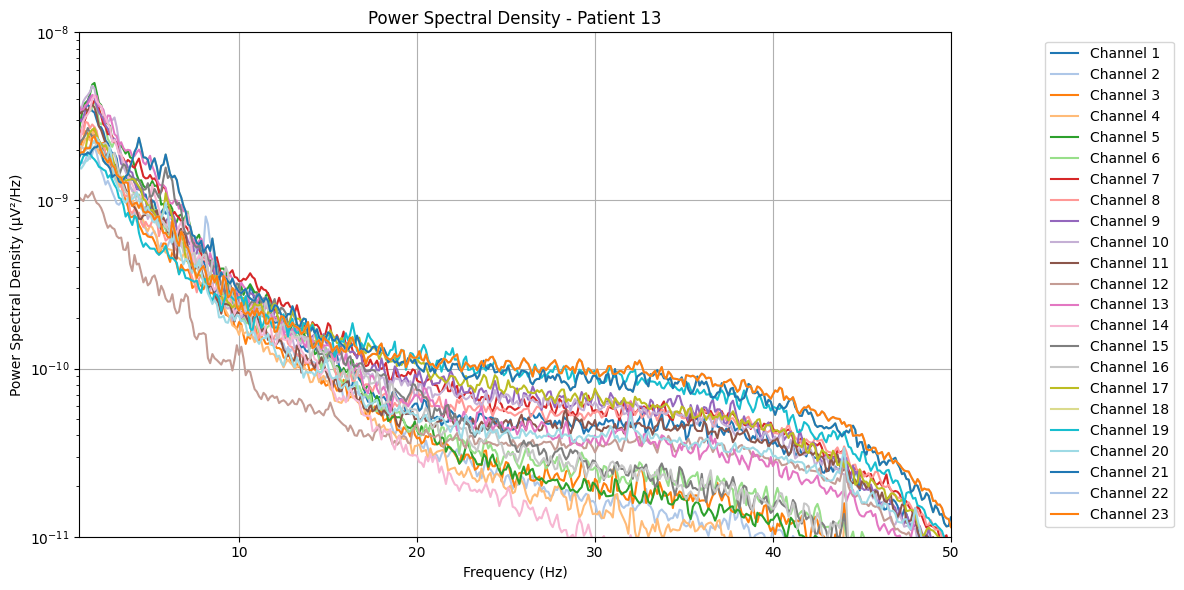

📊 Seizure info loaded for Patient 14


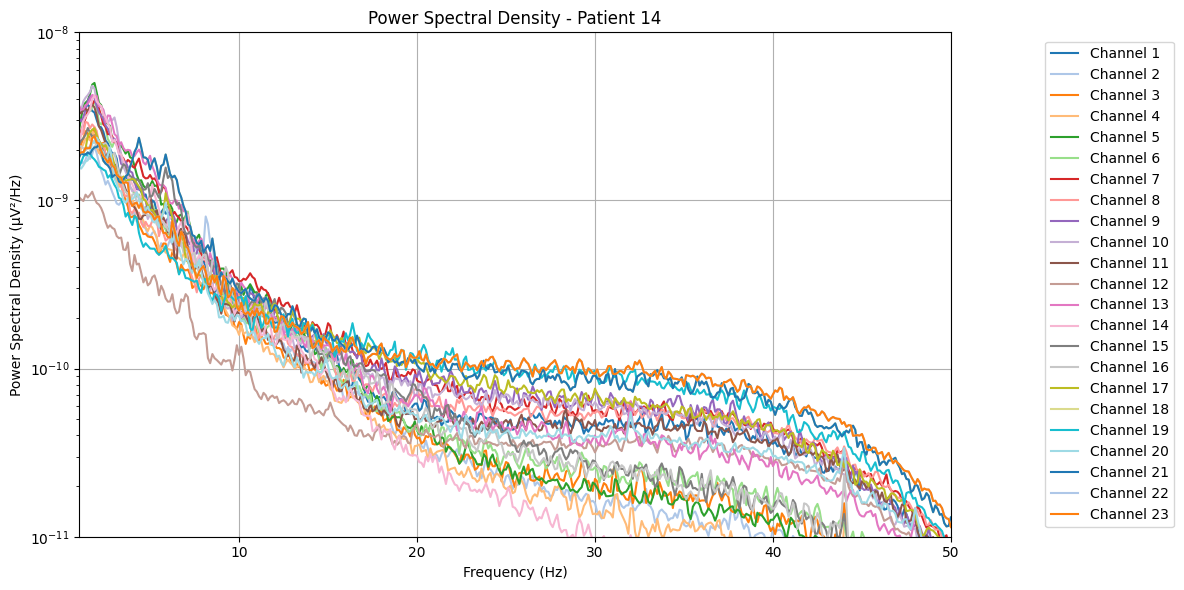

📊 Seizure info loaded for Patient 15


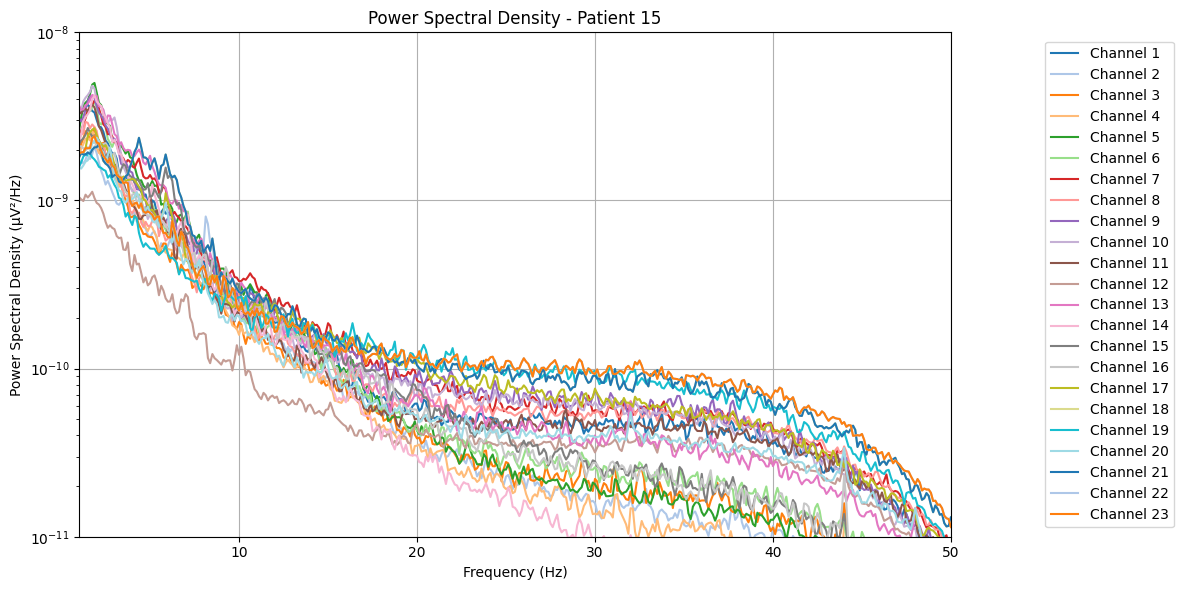

📊 Seizure info loaded for Patient 16


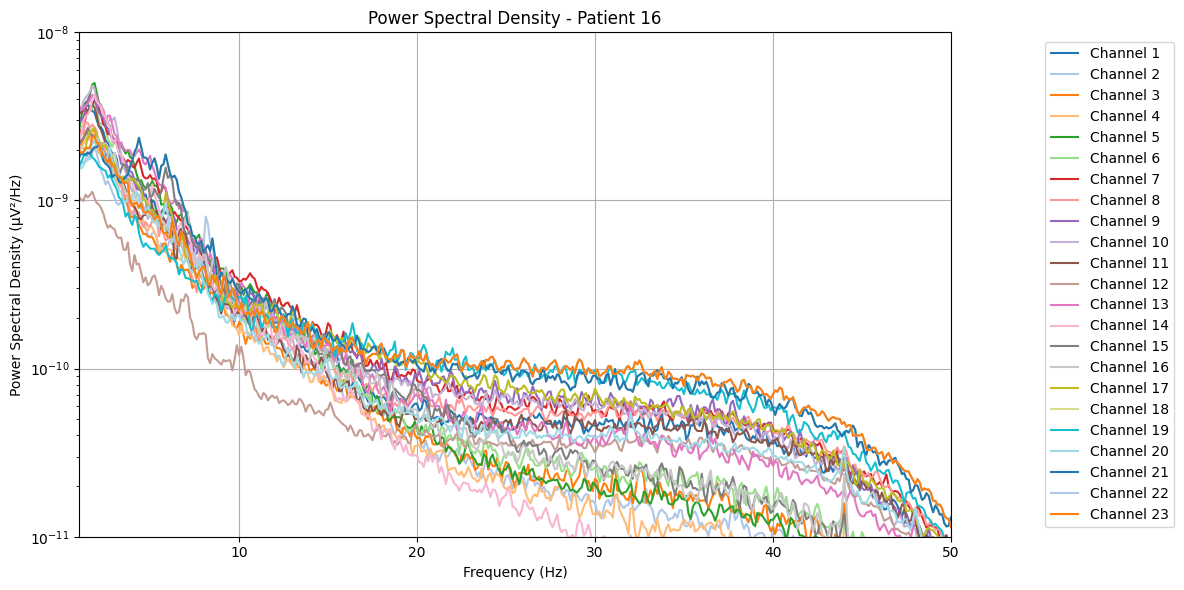

📊 Seizure info loaded for Patient 17


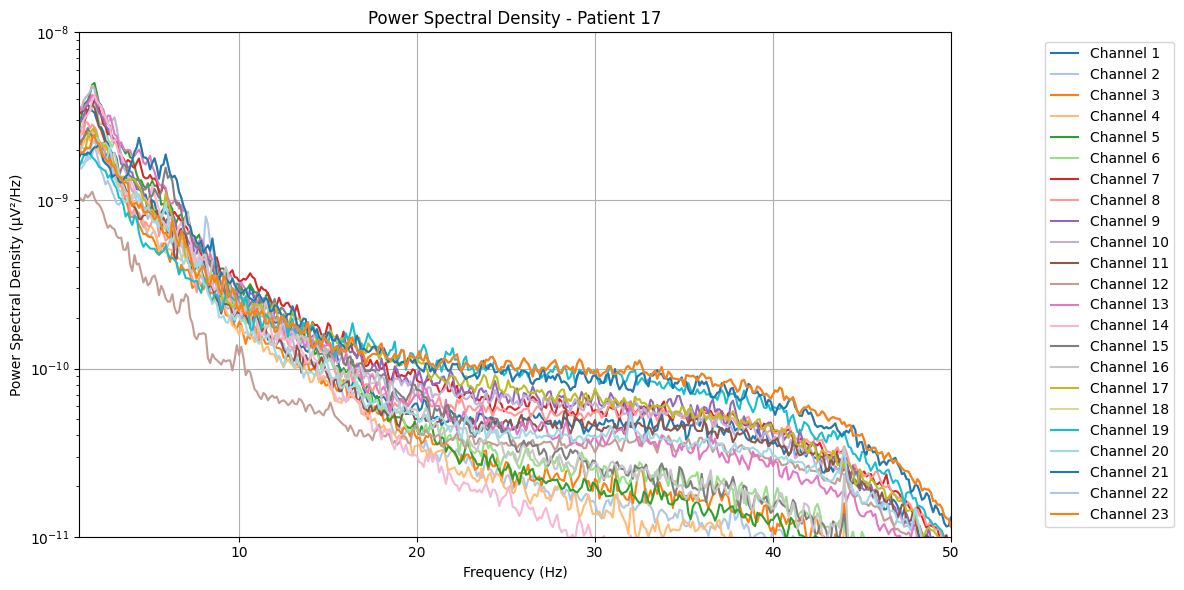

📊 Seizure info loaded for Patient 18


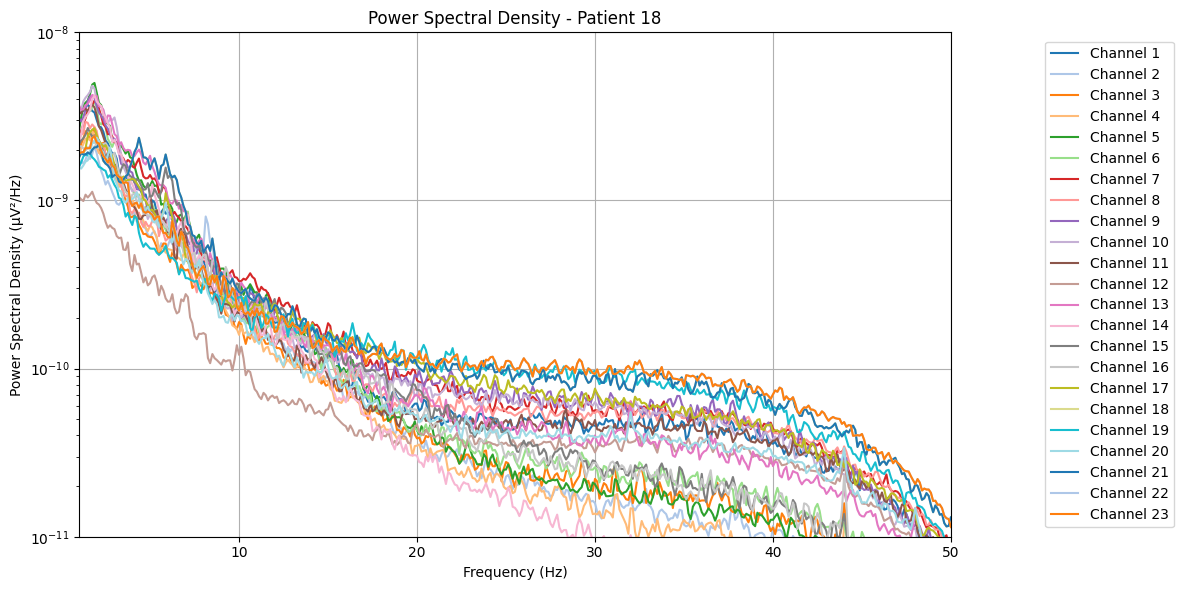

📊 Seizure info loaded for Patient 19


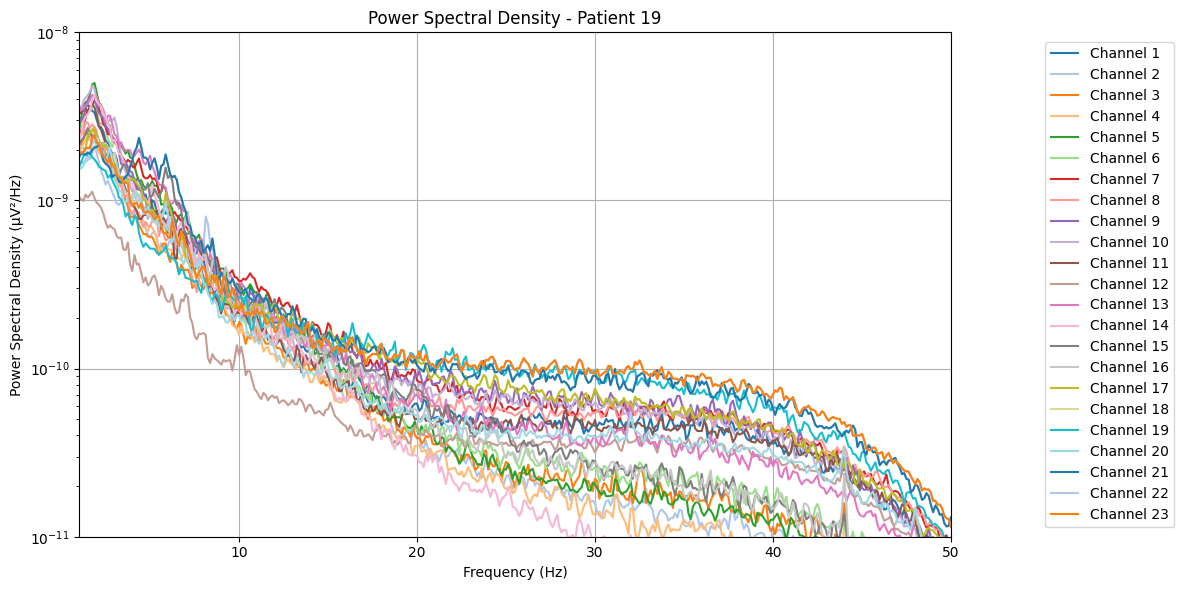

📊 Seizure info loaded for Patient 20


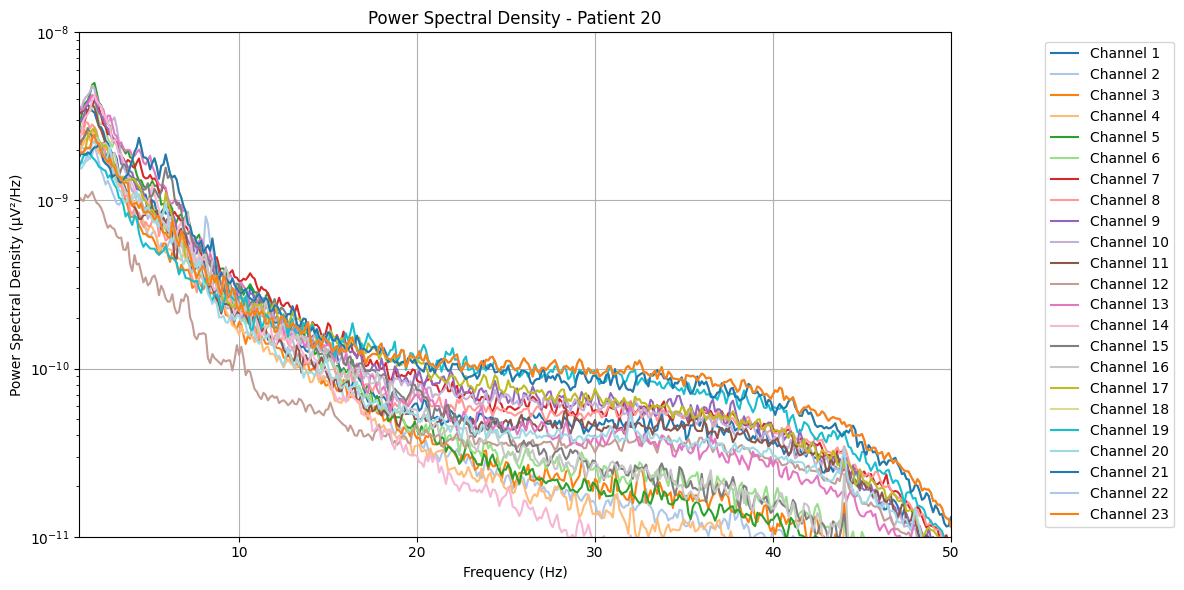

📊 Seizure info loaded for Patient 21


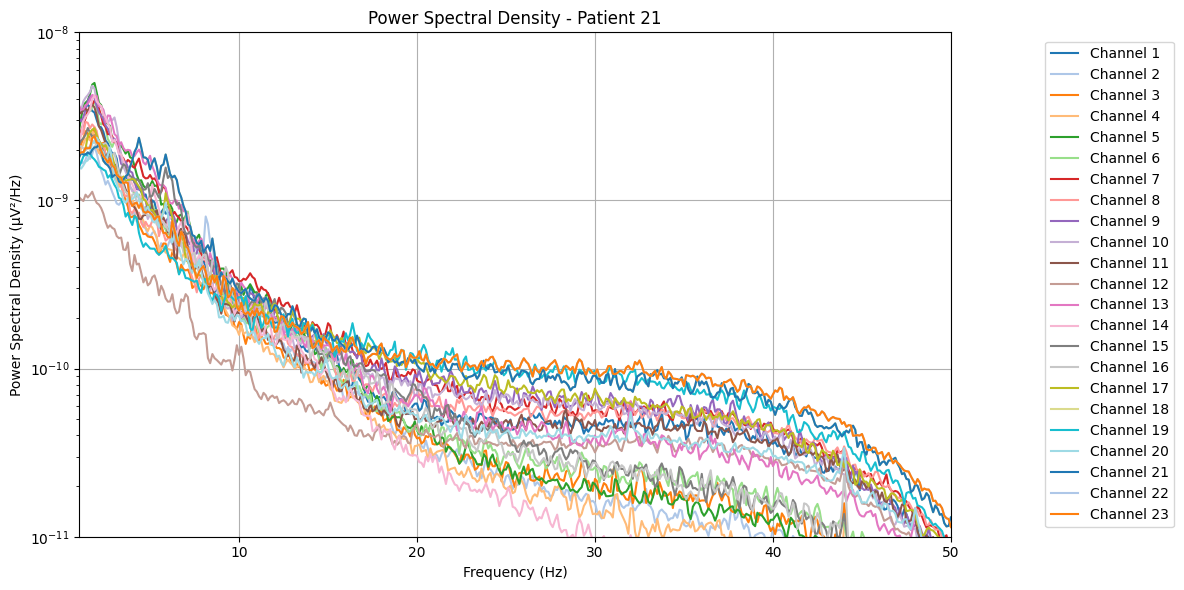

📊 Seizure info loaded for Patient 22


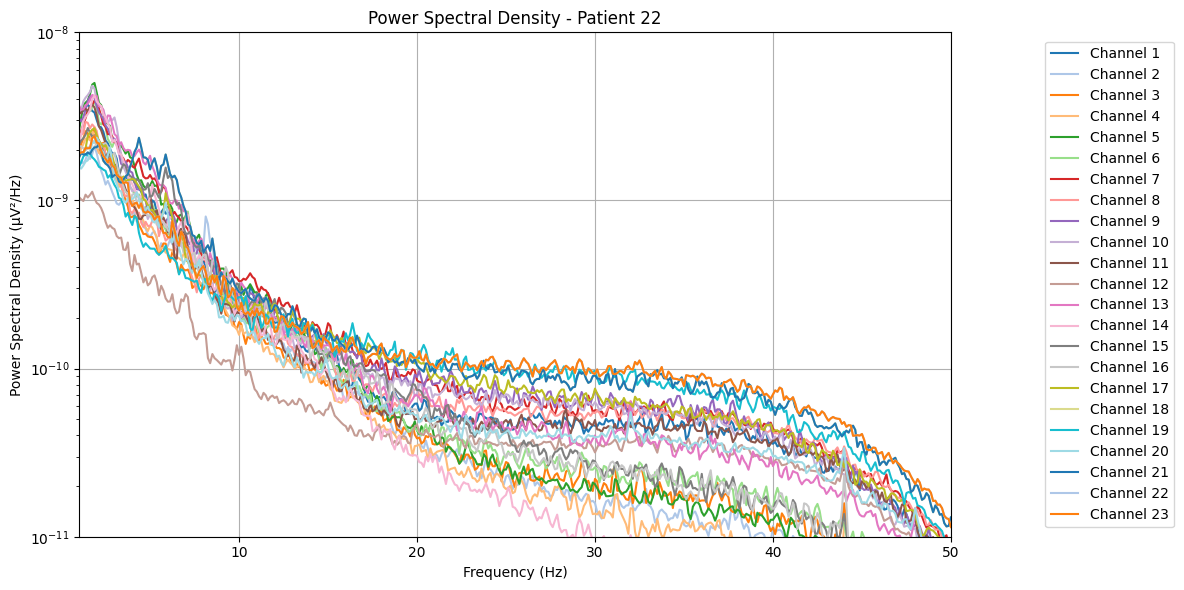

📊 Seizure info loaded for Patient 23


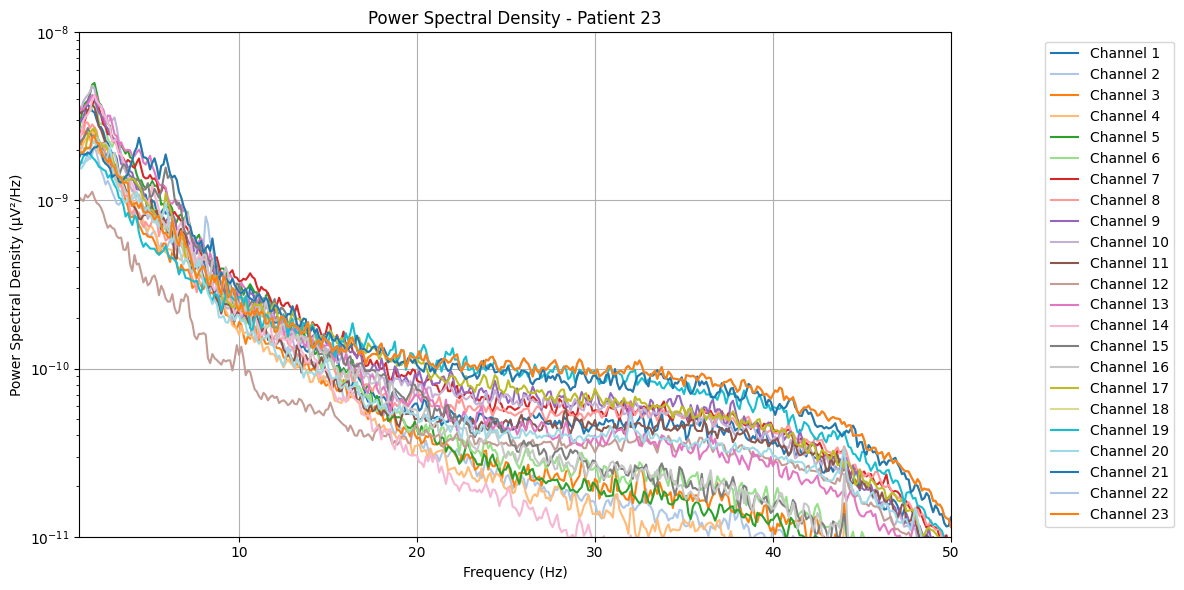

📊 Seizure info loaded for Patient 24


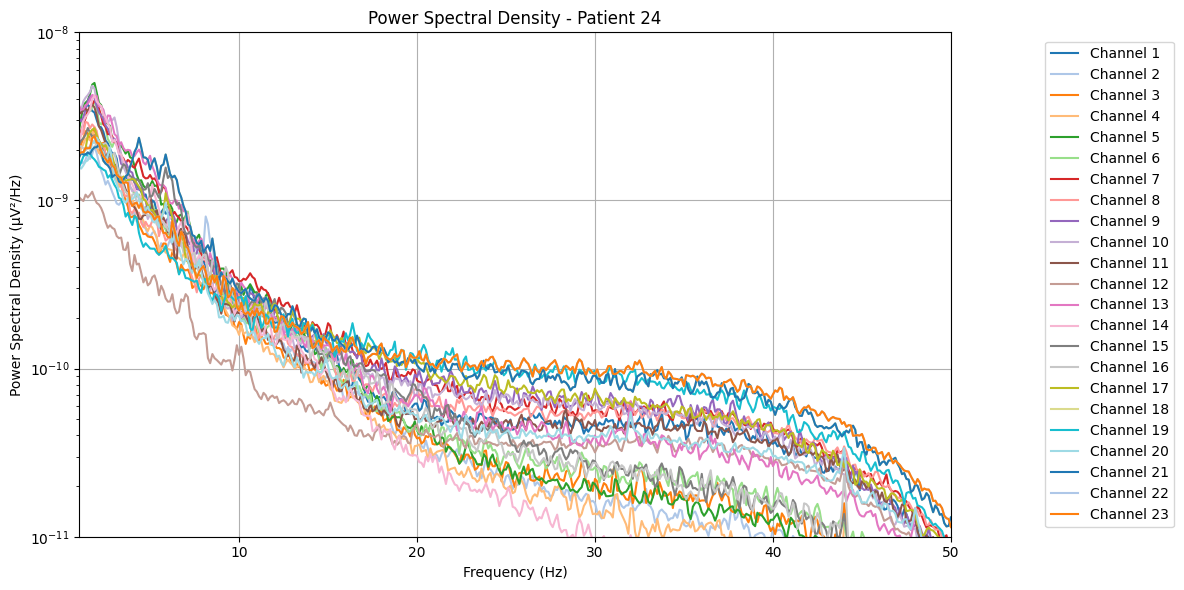

In [17]:
# 🔹 Main Function - Run for All Patients
if __name__ == "__main__":
    fs = 256  # EEG sampling rate
    patient_ids = list(range(1, 25))  # Patients from chb01 to chb24

    # Dictionary to store thread results
    result_dict = {}

    # Start EEG data loading in a separate thread
    eeg_thread = threading.Thread(target=load_eeg_data, args=(result_dict,))
    eeg_thread.start()
    eeg_thread.join()  # Wait for EEG data to finish

    # Retrieve EEG data
    time, eeg_signals = result_dict.get("eeg", (None, None))

    if time is not None and eeg_signals is not None:
        # Process each patient separately
        for patient_id in patient_ids:
            seizure_thread = threading.Thread(target=load_seizure_info, args=(patient_id, result_dict))
            seizure_thread.start()
            seizure_thread.join()

            seizure_df = result_dict.get(patient_id, None)

            if seizure_df is not None:
                psd_plot(fs, time, eeg_signals, patient_id)  # ✅ Compute and plot PSD